## Descripción del Proyecto

El proyecto **Sweet Lift Taxi** se centra en el desarrollo de un modelo predictivo para estimar la demanda de taxis en los aeropuertos durante las horas pico. La compañía ha recopilado un extenso conjunto de datos históricos sobre pedidos de taxis y busca utilizar este conocimiento para optimizar la disponibilidad de vehículos. El objetivo principal es predecir el número de pedidos de taxis en la siguiente hora, con el fin de atraer a más conductores en los momentos de mayor demanda.

El éxito del proyecto se mide mediante la métrica de error cuadrático medio de la raíz (RMSE), con la meta de mantener el RMSE por debajo de 48 en el conjunto de prueba.

## Preparación

* Importamos librerias

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error



In [2]:
df=pd.read_csv('taxi.csv',parse_dates=[0],index_col=[0])
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
print(f'Tenemos {df.isnull().sum().to_list()[0]} valores nulos')
#Al ser una sola columna, no tiene mucho sentido revisar duplicados
#El tipo de dato y el nombre de las columnas son correctos
#Ademàs no tenemos valores nulos

Tenemos 0 valores nulos


In [4]:
#Ordenamos los datos por el indice
df.sort_index(inplace=True)
#Como se busca predecir el numero de ordenes en la proxima hora, es necesario remuestrear el dataset
df=df.resample('1H').sum()#Utilizamos sum para capturar el numero de ordenes en ese tiempo

In [5]:
#Agregamos caracteristicas
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data['estacional']=data['num_orders']-data['lag_1']

make_features(df, 10, 10)

In [6]:
display(df.head(5))

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean,estacional
datetime,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-39.0
2018-03-01 02:00:00,71,2018,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-14.0
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.0
2018-03-01 04:00:00,43,2018,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-23.0


In [7]:
df=df.dropna(axis=0)

## Análisis

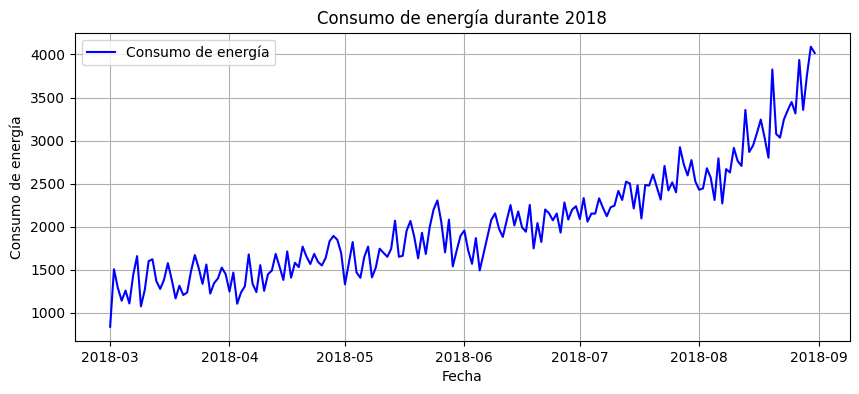

In [8]:
#Grafiquemos el numero de ordenes por dìa
plt.figure(figsize=(10, 4))
data=df['num_orders'].resample('1D').sum()
plt.plot(data.index,data , marker='', linestyle='-', color='b', label='Consumo de energía')
plt.xlabel('Fecha')
plt.ylabel('Consumo de energía')
plt.title('Consumo de energía durante 2018')
plt.legend()
plt.grid(True)
plt.show()
#Podemos observar que la serie temporal es tendencial

- La serie temporal contiene una componente tendecial bastante fuerte.

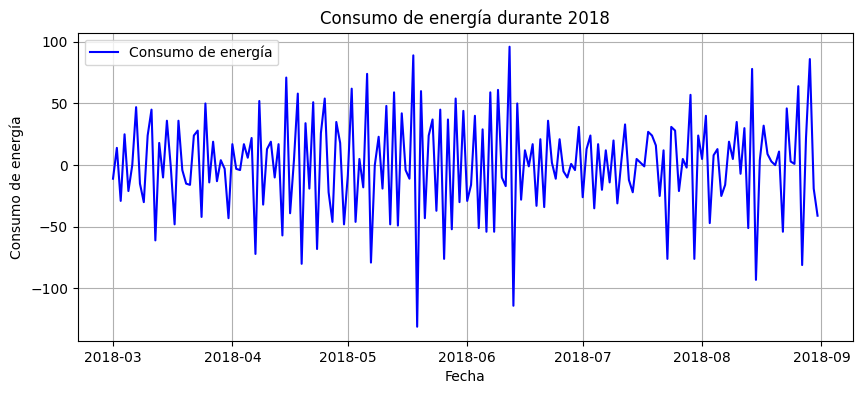

In [9]:
#Grafiquemos los datos promedios por dìa de la caracteristica estacional
plt.figure(figsize=(10, 4))
data=df['estacional'].resample('1D').sum()
plt.plot(data.index,data , marker='', linestyle='-', color='b', label='Consumo de energía')
plt.xlabel('Fecha')
plt.ylabel('Consumo de energía')
plt.title('Consumo de energía durante 2018')
plt.legend()
plt.grid(True)
plt.show()
#Podemos observar que la serie temporal es tendencial

- Podemos notar como restar los datos con los datos y un retraso ayuda a convertir la serie temporal en estacionaria.

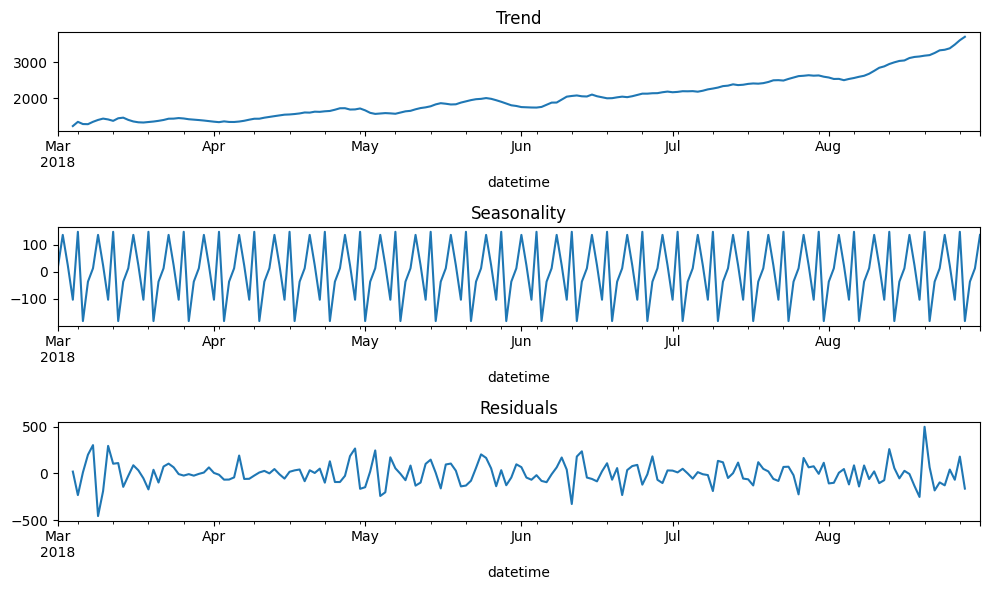

In [10]:
data=df['num_orders'].resample('1D').sum()
decomposed = seasonal_decompose(data)

plt.figure(figsize=(10, 6))
plt.subplot(311)
# Para mostrar el gráfico de manera correcta, especifica su
# eje ax igual a plt.gca() (gca = obtener el eje actual)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

## Formación

In [11]:
#Prueba de cordura
train, test = train_test_split(df, shuffle=False, test_size=0.2,random_state=54321)
print('Nùmero de ordenes diarias:', test['num_orders'].median())
pred_median = np.ones(test['num_orders'].shape[0]) *train['num_orders'].median()
print('EAM:', mean_absolute_error(test['num_orders'],pred_median))

Nùmero de ordenes diarias: 120.0
EAM: 59.493197278911566


In [12]:
def my_train_test_split(df,target_colum, random_state=54321, test_size=0.25):
        # Dividimos el dataset
        df_train, df_valid = train_test_split(df, random_state=54321, test_size=0.2,shuffle=False)
        # Extraemos características y objetivos para capacitación y validación.
        #No debemos incluir estacional como caracteristica, ya que este valor incluye la predicciòn
        features_train = df_train.drop([target_colum,'estacional'],axis=1)
        target_train = df_train[target_colum]
        features_valid = df_valid.drop([target_colum,'estacional'],axis=1)
        target_valid = df_valid[target_colum]
        return features_train,target_train,features_valid,target_valid

In [13]:
def mylinearregression(df,target_colum,columns):
    train_feature,train_target,test_feature,test_target=my_train_test_split(df,target_colum, random_state=54321, test_size=0.25)
    train_feature=train_feature[columns]
    test_feature=test_feature[columns]
    model=LinearRegression()
    model.fit(train_feature,train_target)
    prediccion1=model.predict(train_feature)
    prediccion2=model.predict(test_feature)
    RECM1=mean_squared_error(prediccion1,train_target)**0.5
    RECM2=mean_squared_error(prediccion2,test_target)**0.5
    print("RECM para el conjunto de entrenamiento:", RECM1)
    print("RECM para el conjunto de prueba:", RECM2)




In [14]:
def MyrandomForestRegressor_Tester(df,target_colum,
                                   n_estimators_,
                                   max_depth_,
                                   min_samples_split_=2,
                                   max_features_='sqrt'):
    
    # Extraemos características y objetivos para capacitación y validación.
    features_train,target_train,features_valid,target_valid = my_train_test_split(df,target_colum, 
                                                                                  random_state=54321, 
                                                                                  test_size=0.2)
    
    # Creamos y entrenamos el modelo
    model = RandomForestRegressor(random_state=54321, 
                                  n_estimators=n_estimators_, 
                                  max_depth=max_depth_,
                                  min_samples_split=min_samples_split_,
                                  max_features=max_features_)
    model.fit(features_train, target_train)
        
    # Generamos las predicciones
    predictions_train = model.predict(features_train)
    predictions_valid = model.predict(features_valid)
        
    # Calculamos RMSE
    #rmse = mean_squared_error(target_valid, predictions_valid, squared=False) #Ya no se utiliza ('squared' is deprecated in version 1.4 and will be removed in 1.6.)
    RECM1 = mean_squared_error(target_train,predictions_train)**0.5
    RECM2 = mean_squared_error(target_valid, predictions_valid)**0.5

    # imprimimos los resultados
    print("RECM para el conjunto de entrenamiento:", RECM1)
    print("RECM para el conjunto de prueba:", RECM2)
    return model


In [15]:
def MyLightGBMRegressor_Tester(df, target_column, cat_features_,
                               iterations_=500, depth_=10,
                               learning_rate_=0.01, loss_function_='rmse',period=100):
    
    # Extraemos características y objetivos para capacitación y validación.
    features_train,target_train,features_valid,target_valid = my_train_test_split(df,target_column, 
                                                                                  random_state=54321, 
                                                                                  test_size=0.20)
    
    # Convertimos características categóricas a índices para LightGBM
    for col in cat_features_:
        features_train[col] = features_train[col].astype('category')
        features_valid[col] = features_valid[col].astype('category')

    # Creamos y entrenamos el modelo
    model = lgb.LGBMRegressor(
        n_estimators=iterations_,
        max_depth=depth_,
        learning_rate=learning_rate_,
        objective=loss_function_,
        random_state=42,
        verbose=-1
    )
    
    # Definir el callback de registro
    callbacks = [lgb.log_evaluation(period)]
    
    # Crear los datasets de LightGBM
    train_data = lgb.Dataset(features_train, label=target_train, categorical_feature=cat_features_)
    valid_data = lgb.Dataset(features_valid, label=target_valid, categorical_feature=cat_features_, reference=train_data)
    
    model.fit(features_train, target_train, 
              eval_set=[(features_train, target_train),(features_valid, target_valid)], 
              callbacks=callbacks)
    
    return model

## Prueba

In [16]:
#Entrenemos un modelo de regresion lineal tomando en cuenta todas las caracteristicas
features_train=df.drop(['num_orders','estacional'],axis=1)
print(f'El nùmero total de caracteristicas que se pueden utilizar son: {features_train.shape[1]}')
mylinearregression(df,'num_orders',columns=features_train.columns.to_list()[:16])

El nùmero total de caracteristicas que se pueden utilizar son: 16
RECM para el conjunto de entrenamiento: 28.72912464093869
RECM para el conjunto de prueba: 47.978913047989316


In [17]:
#Entrenemos un modelo de regresion lineal tomando en cuenta solo 10 caracteristicas
print(f'El nùmero total de caracteristicas que se pueden utilizar son: {features_train.shape[1]}')
mylinearregression(df,'num_orders',columns=features_train.columns.to_list()[:10])

El nùmero total de caracteristicas que se pueden utilizar son: 16
RECM para el conjunto de entrenamiento: 29.020295459761137
RECM para el conjunto de prueba: 47.508230366055294


In [18]:
#Entrenemos un arbol de decisiòn
Model=MyrandomForestRegressor_Tester(df,'num_orders',20,20,min_samples_split_=8,max_features_='sqrt')

RECM para el conjunto de entrenamiento: 12.75226940384059
RECM para el conjunto de prueba: 47.59611333430373


In [19]:
#Entrenemos un modelo de potenciaciòn del gradiente
Model_1 = MyLightGBMRegressor_Tester(df, 'num_orders',[], depth_=4, learning_rate_=0.01, iterations_=1000)

[100]	training's rmse: 25.9434	valid_1's rmse: 60.987
[200]	training's rmse: 22.4072	valid_1's rmse: 52.7587
[300]	training's rmse: 20.8624	valid_1's rmse: 49.254
[400]	training's rmse: 19.964	valid_1's rmse: 47.1431
[500]	training's rmse: 19.4288	valid_1's rmse: 45.8642
[600]	training's rmse: 18.9833	valid_1's rmse: 45.1966
[700]	training's rmse: 18.6038	valid_1's rmse: 44.6971
[800]	training's rmse: 18.2918	valid_1's rmse: 44.1565
[900]	training's rmse: 17.9676	valid_1's rmse: 43.7861
[1000]	training's rmse: 17.6411	valid_1's rmse: 43.6806


## Conclusión

A lo largo del proyecto, se realizó un exhaustivo preprocesamiento de datos, enriqueciendo el conjunto con nuevas características que capturan patrones cruciales de la serie temporal. Se evaluaron varios modelos predictivos, y se encontró que el **LightGBMRegressor** ofreció el mejor rendimiento, alcanzando un RMSE de 43.68 en el conjunto de prueba. Este resultado no solo cumple con el objetivo establecido, sino que también destaca la eficacia de los algoritmos de potenciación del gradiente para el análisis de series temporales en problemas de predicción de demanda.

Este proyecto proporciona una base sólida para futuras mejoras en la predicción de la demanda de taxis, permitiendo a Sweet Lift Taxi optimizar su operación y satisfacer mejor la demanda de sus clientes.
